*Luis Antonio Ortega Andrés       
Antonio Coín Castro*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
import scipy.integrate as integrate
import seaborn as sns

# Algoritmo de aceptación y rechazo (A/R)

## Ejercicio 1

Supongamos la función
$$
f(x)=\sin(2\pi x)^5−2\sin\left(3\cos\left(\frac{x}{\pi}\right)^2\right)^3 +3
$$
y el intervalo $(a,b)=(0,10)$. Estimar el área delimitada por la función $f(x)$  en el intervalo $(a,b)$. Evaluar (gráficamente) la precisión (incertidumbre) de la estimación.

*Nota*: la función original se ha modificado porque no coincidía con la gráfica que se muestra en los apuntes.

In [87]:
def plot_f(f, x):
    plt.title("Gráfica de f")
    plt.plot(x,f(x))
    plt.show()

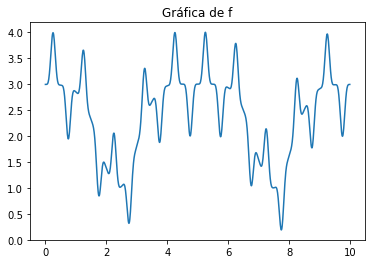

In [106]:
# Mostramos la función
f = lambda x: np.sin(2*np.pi*x)**5 -2*np.sin(3*np.cos(x/np.pi)**2)**3 + 3
x = np.arange(0, 10, 0.01)
plot_f(f,x)

Implementamos el algoritmo de aceptación/rechazo por Monte Carlo.

In [107]:
def mc_ar(f, xlims, ylims, samples = 50000, plot = False, verbose = False):
    x = uniform.rvs(xlims[0], xlims[1] - xlims[0], samples)
    y = uniform.rvs(ylims[0], ylims[1] - ylims[0], samples)
    positives = (0 <= y) &  (y <= f(x))
    negatives = (0 > y) & (y > f(x))
    wrong = np.logical_not(np.logical_or(positives, negatives))
    if plot:
        plt.scatter(x[positives], y[positives], s=1, color="red")
        plt.scatter(x[negatives], y[negatives], s=1, color="purple")
        plt.scatter(x[wrong], y[wrong], s=1, color="blue")
        plt.title(f"Aciertos (rojo) y fallos (azul), nsamples={samples}")

    area_rect = (xlims[1] - xlims[0])*(ylims[1]- ylims[0])
    mean = (sum(positives) - sum(negatives))/samples
    area = area_rect*mean
    if verbose:
        print("Resultado integración:", integrate.quad(f, *xlims)[0], 
              "\nEstimación A/R:", area)
    return area

Probamos este método de integración con nuestra función $f$ en $[0,10]\times[0,5]$, y vemos que conseguimos una buena estimación.

Resultado integración: 23.987186930717478 
Estimación A/R: 24.074


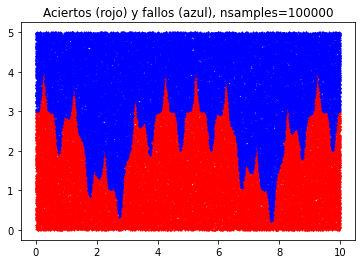

In [108]:
res_ar = mc_ar(f, (0,10), (0,5), samples=100000, plot=True, verbose = True)

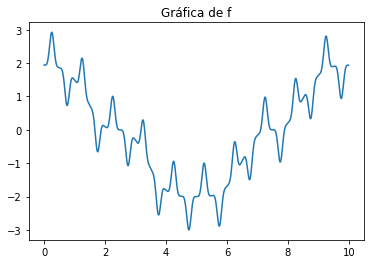

In [99]:
f = lambda x: np.sin(2*np.pi*x)**5 -2*np.cos(3*np.cos(x/np.pi)**2)**3
x = np.arange(0, 10, 0.01)
plot_f(f,x)

Resultado integración: -0.616585682554799 
Estimación A/R: -0.7792


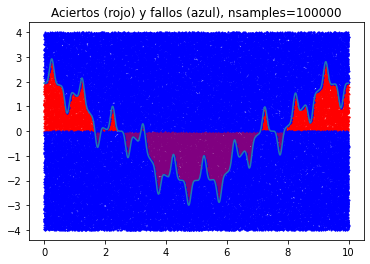

In [105]:
res_ar = mc_ar(f, (0,10), (-4,4), samples=100000, plot=True, verbose = True)
plt.plot(x,f(x))

Para evaluar gráficamente la precisión del método, repetimos el experimento 1000 veces, primero utilizando 1000 lanzamientos en el método A/R, y después utilizando 10000. Pintamos la densidad y la distribución empírica obtenida, y observamos que se asemeja a una normal.

In [6]:
n1, n2 = 1000, 10000
nrep = 1000
res1 = np.array([mc_ar(f, (0,10), (0, 5), n1) for _ in range(nrep)])
res2 = np.array([mc_ar(f, (0,10), (0, 5), n2) for _ in range(nrep)])

In [7]:
# Función para dibujar las gráficas
def plot_kde_ecdf(x1, x2, labels, value):
    _, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].set_title(f"Densidad en {len(x1)} repeticiones con N lanzamientos")
    sns.kdeplot(x1, ax = axes[0], fill = True, label=labels[0])
    sns.kdeplot(x2, ax = axes[0], fill = True, label=labels[1])
    ylims = axes[0].get_ylim()
    axes[0].vlines(value, *ylims, color = "red")
    axes[0].set_ylim(*ylims)
    axes[0].set_xlabel("Área estimada")
    axes[1].set_title("Distribución empírica")
    sns.ecdfplot(x1, ax = axes[1], label=labels[0])
    sns.ecdfplot(x2, ax = axes[1], label=labels[1])
    axes[1].set_xlabel("Área estimada")
    axes[0].legend()
    axes[1].legend()

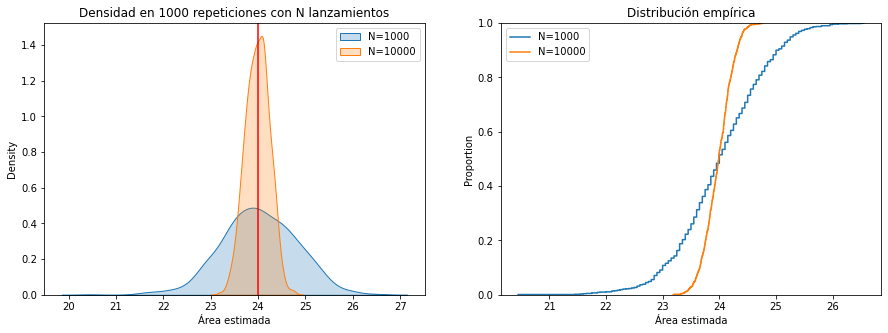

In [8]:
plot_kde_ecdf(res1, res2, [f"N={n1}", f"N={n2}"], res_ar)

# Algoritmo basado en medias

## Ejercicio 2

Calcula la integral
$$
\int_0^1 (1-x^2)^{1/2}\,dx = \frac{\pi}{4}
$$

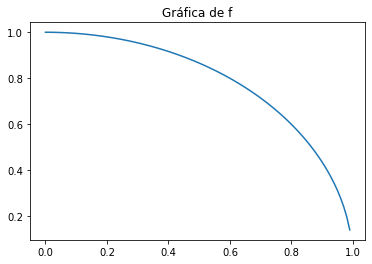

In [9]:
# Mostramos la función
h = lambda x: (1-x**2)**(0.5)
x=np.arange(0,1,0.01)
plot_f(h,x)

Implementamos el algoritmo de Monte Carlo basado en medias.

In [10]:
def mc_means(h, samples = 10000):
    x = uniform.rvs(0, 1, samples)
    return np.mean(h(x))

In [13]:
res_means = mc_means(f)
print("Valor obtenido: ", res_means, "\nValor real: ", np.pi/4)

Valor obtenido:  2.962601245246917 
Valor real:  0.7853981633974483


Comparamos la distribución de 5000 repeticiones del algoritmo basado en medias y del algoritmo de A/R, ambos con 10000 lanzamientos.

In [14]:
nrep=5000
n=10000
res1 = np.array([mc_ar(h, (0,1), (0, 2), n) for _ in range(nrep)])
res2 = np.array([mc_means(h, n) for _ in range(nrep)])

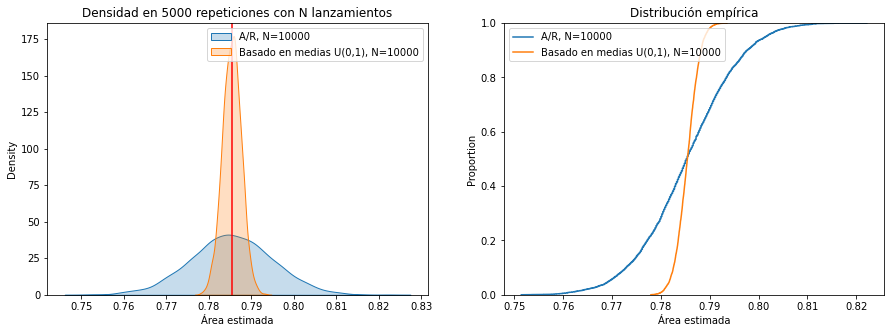

In [15]:
plot_kde_ecdf(res1, res2, ["A/R, N=10000", "Basado en medias U(0,1), N=10000"], np.pi/4)

Realizamos ahora varias repeticiones de la estimación basada en medias, aumentando paulatinamente el número de puntos desde 1 hasta 50000, proporcionando también un intervalo de confianza al 99.5% en cada caso. A la hora de dibujarlo comenzamos desde 50 puntos para visualizarlo mejor, ya que con pocos puntos la varianza es muy grande.

In [16]:
def mc_means_cummulative(h, x, alpha = 0.005, offset=0):
    y = h(x)
    
    # Establecemos la sucesión de puntos
    size = np.arange(start = 1, stop = len(x)+1, step = 1)

    # Calculamos la media de h progresivamente en todos los puntos 
    media = np.cumsum(y) / size

    # Calculamos el valor z_alpha para el intervalo de confianza
    z_alpha = norm.ppf(1-alpha/2)

    # Calculamos la varianza
    s2 = (y - media) * (y - media)
    s2[1:] = np.cumsum(s2)[1:]/size[0:-1]
    
    # Calculamos el intervalo de confianza
    ic = z_alpha*np.sqrt(s2)/np.sqrt(size)

    return media[offset:], ic[offset:]

In [46]:
def cum_sample_plot(f, n_samples, real_value = None, offset = 0, ax = None, print_ic = False):
    
    x = uniform.rvs(0,1, n_samples + offset)
    
    size=np.arange(start = offset+1, stop = len(x)+1, step = 1)
    
    if ax is None:
        fig, ax = plt.subplots()
    
    media, ic = mc_means_cummulative(f, x, alpha=0.005, offset=offset)
    sns.lineplot(x = np.arange(start = 1, stop = len(media)+1, step = 1), y = media, lw=.2, ax=ax)
    if real_value is not None:
        ax.plot([offset, len(x)], 2*[real_value], color='k', lw=.75)
    ax.set_xlabel("Sample size")
    ax.set_ylabel(r"Estimated integral value")
    ax.set_title(r"Importance sampling, $\mathcal{U}(0,1)$, $\alpha=0.005$")

    if print_ic:
        # Dibujamos los intervalos de confianza de forma continua
        ax.fill_between(size, media-ic, media+ic, color='b', alpha=.2)


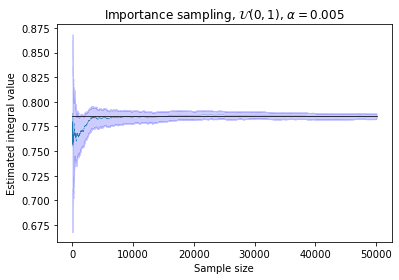

In [47]:
cum_sample_plot(h, 50000, np.pi/4, 50, print_ic = True)
plt.show()

Ahora realizamos 100 ejecuciones independientes del experimento desde 1 hasta 30000 puntos, y mostramos los resultados.

Calculando las 100 iteraciones del experimento: [====================] 100%

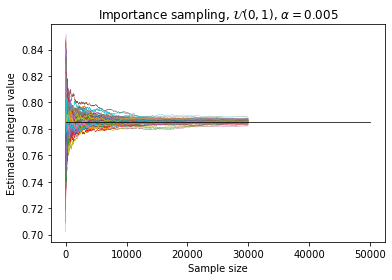

In [39]:
import sys

fig, ax = plt.subplots()
ax.set_title("100 independent simulations")
ax.set_xlabel("Sample size")
ax.set_ylabel(r"Estimated integral value, $\pi/4$")

for i in range(100):
    # Display waiting bar
    sys.stdout.write('\r')
    sys.stdout.write("Calculando las 100 iteraciones del experimento: [%-20s] %d%%" % ('='*((i+5)//5), i+1))
    sys.stdout.flush()
    cum_sample_plot(h, 30000, offset = 50, ax = ax, print_ic = False)

ax.plot([0, 30000], 2*[np.pi/4], color='k', lw=.75)
plt.show()

# Muestreo por importancia
## Ejercicio 3

Estimar la integral
$$
\int_0^1 \cos(50x)+\sin(20x)\, dx
$$

por Monte Carlo. Analice la convergencia de la estimación en función del tamaño de la muestra y proporcione un intervalo de confianza.

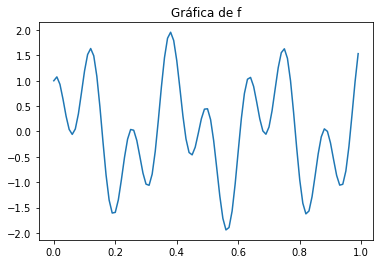

In [40]:
f=lambda x: np.cos(50*x)+np.sin(20*x)
x=np.arange(0, 1, 0.01)
plot_f(f,x)

Aplicamos el método de *importance sampling* como antes, proporcionando intervalos de confianza.

In [49]:
# Calculamos el área real
area=(1/50) *(5 * np.sin(10)**2 + np.sin(50))

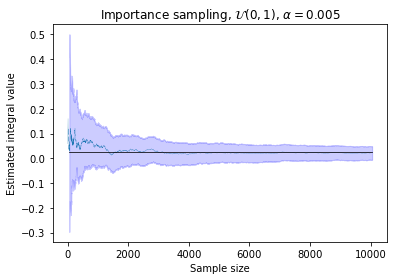

In [50]:
cum_sample_plot(f, 10000, area, 50, print_ic = True)
plt.show()

## Ejercicio 4

Estimar el valor de la integral
$$
\int_0^{10}e^{-2|x-5|}
$$

In [159]:
def importance_sampling(f, x, density, samples=10000, alpha = 0.005, offset=0):    
    y = f(x)/[density(a) for a in x]
    
    # Establecemos la sucesión de puntos
    size = np.arange(start = 1, stop = samples+1, step = 1)

    # Calculamos la media de h progresivamente en todos los puntos 
    media = np.cumsum(y) / size

    # Calculamos el valor z_alpha para el intervalo de confianza
    z_alpha = norm.ppf(1-alpha/2)

    # Calculamos la varianza
    s2 = (y - media) * (y - media)
    s2[1:] = np.cumsum(s2)[1:]/size[0:-1]
    
    # Calculamos el intervalo de confianza
    ic = z_alpha*np.sqrt(s2)/np.sqrt(size)

    return media[offset:], ic[offset:]

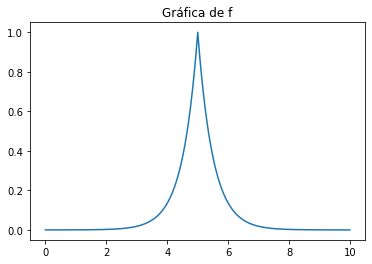

In [160]:
f = lambda x: np.exp(-2*np.abs(x - 5))
plot_f(f, np.arange(0, 10, 0.01))

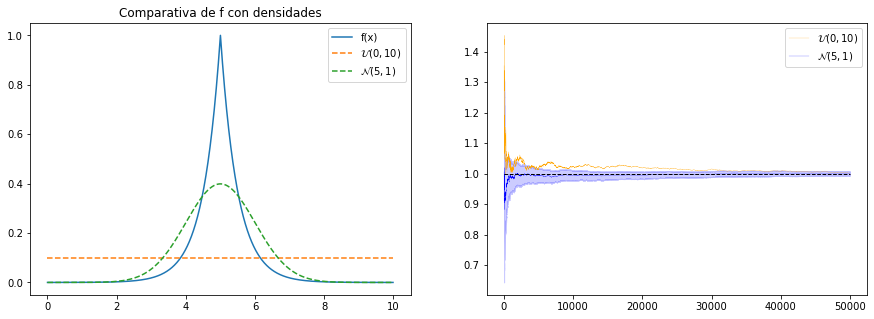

In [173]:
_, axes = plt.subplots(1, 2, figsize=(15,5))

# Axes 0
x = np.arange(0, 10, 0.01)
axes[0].set_title("Comparativa de f con densidades")
axes[0].plot(x,f(x), label = "f(x)")
axes[0].plot([0,10], 2*[1/10], '--', label = r"$\mathcal{U}(0,10)$")
axes[0].plot(x, norm.pdf(x, 5, 1), '--', label=r'$\mathcal{N}(5,1)$')
axes[0].legend()

samples = 50000
offset = 20

capped_norm = lambda x: 0 if (x < 0) or (x > 10) else norm.pdf(x,5,1)

media1, ic1 = importance_sampling(f, uniform.rvs(0, 10, samples+offset), density = lambda x: 1/10, 
                                  samples=samples + offset, 
                                  alpha=0.005, offset=offset)

sns.lineplot(x = np.arange(start = 1, stop = samples+1, step = 1), y = media1, lw=.2, color = 'orange', ax=axes[1],
            label = r'$\mathcal{U}(0, 10)$')

media2, ic2 = importance_sampling(f, norm.rvs(5, 1, samples+offset), density = capped_norm, 
                                  samples=samples + offset, 
                                  alpha=0.005, offset=offset)
sns.lineplot(x = np.arange(start = 1, stop = samples+1, step = 1), y = media2, lw=.2, color = 'b', ax=axes[1],
            label = r'$\mathcal{N}(5,1)$')
axes[1].fill_between(np.arange(start = 1, stop = samples+1, step = 1), media2-ic2, media2+ic2, color='b', alpha=.2)
axes[1].plot([0, samples], 2*[1], '--', lw = 1, color = "black", )